# Library

In [1]:
try:
    import json 
    import csv
    import os
    from math import sin, cos, sqrt, atan2, radians

    import networkx as nx

    from folium import *
    from folium import plugins

    import pandas as pd

    import plotly.express as px
    
except:
    %pip install folium
    %pip install pandas
    %pip install networkx

# From GeoJSON to Multiplex Graph

In [2]:
class ParisTransportation:
    """
    Main class
    """

    def __init__(self):
        self.jsonfile = "geojson/multigraph.geojson"

    def clean_data(self):
        if not os.path.exists("gml"):
            os.makedirs("gml")

        G = nx.DiGraph() #total
        H = nx.Graph() #road
        Q = nx.Graph() #metro
        I = nx.Graph() #train
        O = nx.Graph() #tram

        with open(self.jsonfile, 'r') as jsfile:
            for line in jsfile:
                jsentry = json.loads(line)
                if jsentry['properties']['type'] == "edge":
                    if 'direction' in jsentry['properties']:
                        if jsentry['properties']['direction'] == "Double sens":
                            direction = "TwoWay"
                        elif (jsentry['properties']['direction'] == "Sens inverse" 
                            or jsentry['properties']['direction'] == "Sens unique"):
                            direction = "OneWay"
                    else:
                        direction = "TwoWay"

                    ID = jsentry['_id']['$oid']
                    Source = jsentry['properties']['mongo_org_id']
                    Target = jsentry['properties']['mongo_dest_id']
                    Layer = jsentry['properties']['layer']
                    Coordinates = jsentry['geometry']['coordinates']
                    Direction = direction

                    try:
                        Length = jsentry['properties']['length']
                    except:
                        Length = None
                    try:
                        Name = jsentry['properties']['name']
                        if Name.startswith("54"):
                            Name = None
                    except:
                        Name = None

                    degreeDual = jsentry['properties']['degreeDual']

                    #print(f"[{Layer}] -> {Direction}")
                    
                    """if Direction == "OneWay" and Layer == "road":
                        H.add_edge(
                            Source, 
                            Target, 
                            id = ID, 
                            coord = Coordinates, 
                            length=Length, 
                            name=Name, 
                            degreeDual=degreeDual,
                            layer=Layer)
                        H.nodes[Source]['pos'] = (Coordinates[0][1],Coordinates[0][0])
                        H.nodes[Source]['layer'] = Layer
                        H.nodes[Target]['pos'] = (Coordinates[1][1],Coordinates[1][0])
                        H.nodes[Target]['layer'] = Layer"""

                    if Layer == "road":
                        H.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #H.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        H.nodes[Source]['pos'] = (Coordinates[0][1],Coordinates[0][0])
                        H.nodes[Source]['layer'] = Layer
                        H.nodes[Target]['pos'] = (Coordinates[1][1],Coordinates[1][0])
                        H.nodes[Target]['layer'] = Layer

                    elif Layer == "metro":
                        Q.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #Q.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        Q.nodes[Source]['pos'] = (Coordinates[0][1],Coordinates[0][0])
                        Q.nodes[Source]['layer'] = Layer
                        Q.nodes[Target]['pos'] = (Coordinates[1][1],Coordinates[1][0])
                        Q.nodes[Target]['layer'] = Layer

                    elif Layer == "train":
                        I.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #I.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        I.nodes[Source]['pos'] = (Coordinates[0][1],Coordinates[0][0])
                        I.nodes[Source]['layer'] = Layer
                        I.nodes[Target]['pos'] = (Coordinates[1][1],Coordinates[1][0])
                        I.nodes[Target]['layer'] = Layer

                    elif Layer == "tram":
                        O.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #O.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        O.nodes[Source]['pos'] = (Coordinates[0][1],Coordinates[0][0])
                        O.nodes[Source]['layer'] = Layer
                        O.nodes[Target]['pos'] = (Coordinates[1][1],Coordinates[1][0])
                        O.nodes[Target]['layer'] = Layer

                    else:
                        continue
                else:
                    continue

            return(G, H, Q, I, O)


    def geoJSON(self):
        df = pd.read_json('geojson/multigraph.geojson', lines=True)
        id = pd.json_normalize(df["_id"])
        id = id.rename(columns={"$oid": "ID"})

        geom = pd.json_normalize(df["geometry"])
        geom = geom.rename(columns={"type": "LP"})

        prop = pd.json_normalize(df["properties"])

        new_df = pd.concat([id, geom, prop], axis=1)
        return(new_df)
    
    class MapMaker:
        def __init__(self, df):
            self.df = df
            self.only_point = df.loc[df['LP'] == "Point"]
            self.points = self.only_point.coordinates.tolist()
            self.center = (48.85654066902656, 2.349154275836)
            self.canvas = True,
            self.bounds = True,
            self.filename = "france.html"
            self.layerColor = {
                "road": "green",
                "train": "blue",
                "metro": "gray",
                "tram": "purple"
            }

        @staticmethod
        def calculate_distance(lon1, lat1, lon2, lat2, R=6357):
            lat1 = radians(lat1)
            lat2 = radians(lat2)
            lon1 = radians(lon1)
            lon2 = radians(lon2)

            dlon = lon2 - lon1
            dlat = lat2 - lat1

            a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            distance = R * c
            return distance
        
        def create_map(self):
            if not os.path.exists(self.filename):
                m = Map(location=[self.center[0], self.center[1]], 
                    tiles="CartoDB positron", 
                    min_zoom=7, 
                    zoom_start=9,
                    zoom_control=True, 
                    min_lat=42, 
                    max_lat=54, 
                    min_lon=-10, 
                    max_lon=14, 
                    max_bounds=self.bounds,
                    prefer_canvas=self.canvas)

                minimap = plugins.MiniMap()
                m.add_child(minimap)

                layers = self.only_point.layer.unique().tolist()

                fg = FeatureGroup(control=False, show=False)
                m.add_child(fg)

                f1 = plugins.FeatureGroupSubGroup(fg, layers[0].capitalize())
                m.add_child(f1)

                f2 = plugins.FeatureGroupSubGroup(fg, layers[1].capitalize())
                m.add_child(f2)

                f3 = plugins.FeatureGroupSubGroup(fg, layers[2].capitalize())
                m.add_child(f3)

                f4 = plugins.FeatureGroupSubGroup(fg, layers[3].capitalize())
                m.add_child(f4)

                i = 0
                layerTypes = self.only_point.layer.tolist()

                for lon, lat in self.points:

                    distance = self.calculate_distance(lon, lat, self.center[1], self.center[0])
                    radiusDistance = distance

                    if int(distance) > 0:
                        distance = int(distance)
                        distance = f"{distance} km"
                    else:
                        distance = distance * 1000
                        distance = int(distance)
                        distance = f"{distance} mt"

                    circle = Circle(
                        location=(lat, lon),
                        tooltip=f"<strong>Type:</strong> {layerTypes[i]}<br><strong>Center distance:</strong> {distance}",
                        radius=sqrt(radiusDistance * 1000),
                        popup=f"<strong>Type:</strong> {layerTypes[i]}<br><strong>Lat:</strong> {lat}<br><strong>Long:</strong> {lon}<br><strong>Center distance:</strong> {distance}",
                        color=self.layerColor.get(layerTypes[i]),
                        fill=False,
                        fill_color=self.layerColor.get(layerTypes[i])
                    )
                    
                    if layerTypes[i] == layers[0]:
                        f1.add_child(circle)
                    elif layerTypes[i] == layers[1]:
                        f2.add_child(circle)
                    elif layerTypes[i] == layers[2]:
                        f3.add_child(circle)
                    elif layerTypes[i] == layers[3]:
                        f4.add_child(circle)

                    i +=1

                paris = Circle(
                    location=(self.center[0], self.center[1]),
                    tooltip="Center",
                    popup="",
                    radius=80,
                    color="crimson",
                    fill=True,
                    fill_color="crimson"
                )
                paris.add_to(fg)

                plugins.Fullscreen(
                        position="topright",
                        title="Fullscreen",
                        title_cancel="Exit fullscreen",
                        force_separate_button=True,
                    ).add_to(m)

                LayerControl().add_to(m)
                m.save(self.filename)

In [3]:
G, ROAD, METRO, TRAIN, TRAM = ParisTransportation().clean_data()

In [4]:
df = ParisTransportation().geoJSON()

In [5]:
ParisTransportation().MapMaker(df).create_map()

# Summary of Multiplex Network Layers

In [26]:
CC_TRAIN = TRAIN.subgraph(max(nx.connected_components(TRAIN), key=len))
CC_TRAM = TRAM.subgraph(max(nx.connected_components(TRAM), key=len))
CC_ROAD = ROAD.subgraph(max(nx.connected_components(ROAD), key=len))

In [6]:
summary_table = pd.DataFrame({
    "Nodes" : [
        len(METRO.nodes), 
        len(TRAIN.nodes),
        len(TRAM.nodes),
        len(ROAD.nodes)],
    "Edges" : [
        len(METRO.edges), 
        len(TRAIN.edges),
        len(TRAM.edges),
        len(ROAD.edges)],
    "Avg. Degree" : [
        sum(dict(METRO.degree()).values())/float(len(METRO)),
        sum(dict(TRAIN.degree()).values())/float(len(TRAIN)),
        sum(dict(TRAM.degree()).values())/float(len(TRAM)),
        sum(dict(ROAD.degree()).values())/float(len(ROAD))],
    "Reference" : ["OSM", "OSM", "OSM", "IGN"]
}, index=["Metro", "Train", "Tram", "Road"])
summary_table

,Nodes,Edges,Avg. Degree,Reference
Metro,303,356,2.349835,OSM
Train,241,244,2.024896,OSM
Tram,144,140,1.944444,OSM
Road,14804,22281,3.010132,IGN


# Nodes distribution

In [7]:
DF = df.loc[df['LP'] == "Point"]
DF = DF.drop_duplicates(subset="ID")
px.pie(
    values=DF.groupby('layer')['layer'].count().sort_values(ascending=False).values.tolist(), 
    names=DF.layer.unique().tolist(), 
    title='Nodes distribution')

# 3D Plot of Layers

c:\Users\Matte\AppData\Local\Programs\Python\Python38\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning:

Error: node 5453b63455474a3362317782, position (48.8468543, 2.3166512), expected two doubles
Error: node 5453b63555474a336231a0f6, position (48.8491398, 2.3218984), expected two doubles
Error: node 5453b63455474a3362317781, position (48.8514, 2.3143901), expected two doubles
Error: node 5453b63555474a336231a513, position (48.8419339, 2.3211592), expected two doubles
Error: node 5453b63555474a336231ac99, position (48.8470802, 2.3076354), expected two doubles
Error: node 5453b63455474a3362318658, position (48.8514587, 2.3267159), expected two doubles
Error: node 5453b63555474a336231a9a0, position (48.840669, 2.2287175), expected two doubles
Error: node 5453b63455474a3362318fdf, position (48.8420002, 2.2387333), expected two doubles
Error: node 5453b63455474a33623198be, position (48.8477655, 2.2583922), expected two doubles
Error: node 5453b63455474a3362317de4, position (48.

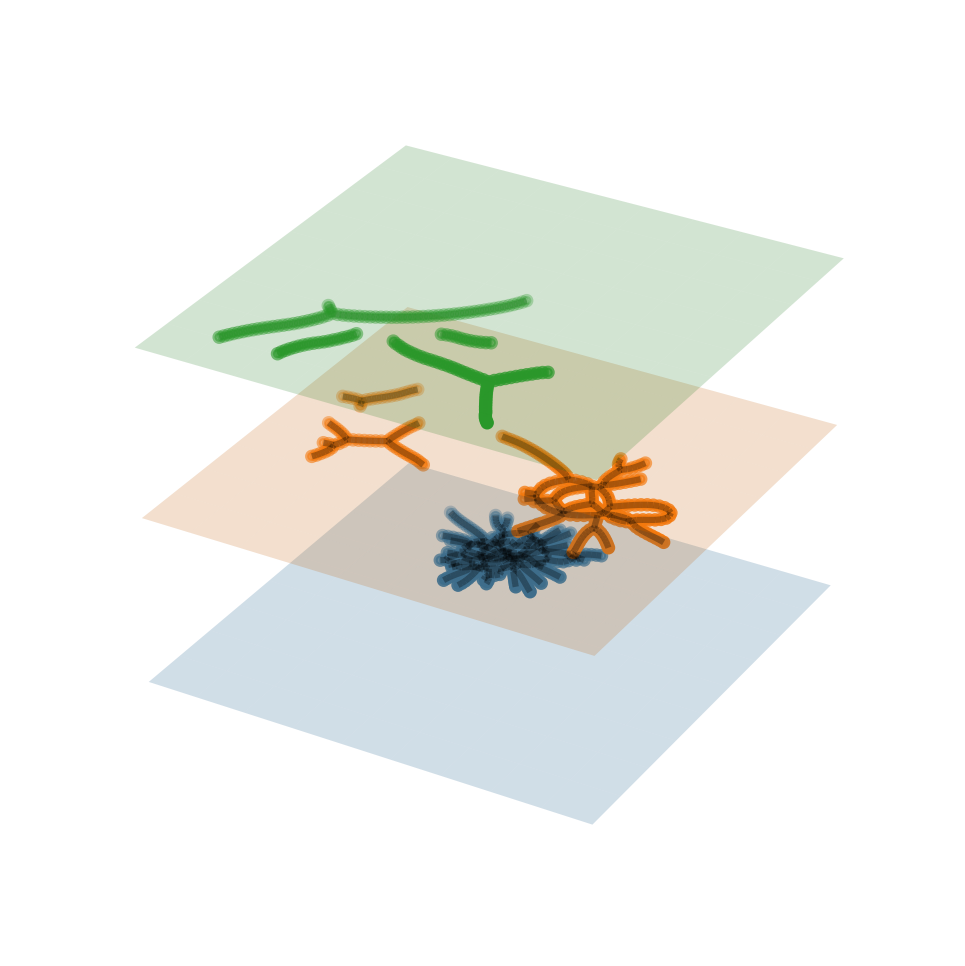

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from networkx.drawing.nx_agraph import graphviz_layout

mpl.rcParams['figure.dpi'] = 300
class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=5, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)


if __name__ == '__main__':

    # define graphs
    n = 5
    g = METRO
    h = TRAIN
    i = TRAM

    node_labels = {nn : str(nn) for nn in range(4*n)}

    # initialise figure and plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    LayeredNetworkGraph([g, h, i], ax=ax, layout=graphviz_layout) # graphviz
    ax.set_axis_off()
    plt.show()

In [8]:
pd.DataFrame.from_dict(dict(METRO.nodes(data=True)), orient='index')

,pos,layer
5453b63455474a3362317782,"(48.8468543, 2.3166512)",metro
5453b63555474a336231a0f6,"(48.8491398, 2.3218984)",metro
5453b63555474a336231a9a0,"(48.840669, 2.2287175)",metro
5453b63455474a3362318fdf,"(48.8420002, 2.2387333)",metro
5453b63555474a336231a0ba,"(48.8499051, 2.348746)",metro
...,...,...
5453b63555474a336231a245,"(48.8807774, 2.3741125)",metro
5453b63455474a33623182c5,"(48.8749537, 2.3402103)",metro
5453b63455474a336231776c,"(48.846474, 2.3659107)",metro
5453b63355474a33623172b0,"(48.8869632, 2.3867135)",metro


In [62]:
#for key, value in dict(METRO.edges()).items():
#    print(key)
metro_df = edges2df(METRO)
train_df = edges2df(TRAIN)
road_df = edges2df(ROAD)
tram_df = edges2df(TRAM)

In [64]:
train_df[train_df.name=="RER E"]

,source,target,coord,length,name,degreeDual,layer
id,,,,,,,
54b7bef755474a2bb2744f10,5453b63555474a336231aedb,5453b63455474a3362317e21,"[[48.7956697, 2.6503883], [48.770724, 2.6902929]]",4.030165,RER E,338,train
54b7bef855474a2bb2748f70,5453b63555474a336231aedb,5453b63455474a3362317f60,"[[48.8061102, 2.6184322], [48.7956697, 2.65038...",2.612619,RER E,338,train
54b7bef855474a2bb2747093,5453b63455474a3362317e21,5453b63455474a3362319236,"[[48.7454489, 2.7285636], [48.770724, 2.6902929]]",3.971016,RER E,338,train
54b7bef755474a2bb2744f11,5453b63455474a33623188f0,5453b63555474a336231ab6f,"[[48.8230136, 2.5801235], [48.8232568, 2.54252...",2.752504,RER E,338,train
54b7bef855474a2bb2749542,5453b63455474a33623188f0,5453b63455474a3362317f60,"[[48.8061102, 2.6184322], [48.8230136, 2.58012...",3.376532,RER E,338,train
54b7bef855474a2bb27469fc,5453b63555474a336231ab6f,5453b63455474a3362319386,"[[48.8248565, 2.511885], [48.8232568, 2.5425275]]",2.250311,RER E,338,train
54b7bef855474a2bb27469ec,5453b63455474a33623183f2,5453b63555474a336231a036,"[[48.8703405, 2.485847], [48.8541841, 2.4892001]]",1.813177,RER E,338,train
54b7bef855474a2bb27469f6,5453b63455474a33623183f2,5453b63555474a336231a8a6,"[[48.8703405, 2.485847], [48.8825092, 2.4812324]]",1.394547,RER E,338,train
54b7bef855474a2bb274953b,5453b63555474a336231a036,5453b63455474a33623191a1,"[[48.8390089, 2.4942347], [48.8541841, 2.48920...",1.727154,RER E,338,train


In [79]:
import folium


In [155]:
class TransportMap:
    def __init__(self, metro_layer, train_layer, tram_layer):
        self.metro_layer = metro_layer
        self.train_layer = train_layer
        self.tram_layer = tram_layer
    
    @staticmethod
    def edges2df(G, id_indexed: bool = True):
        df = pd.DataFrame(dict(G.edges()).items(),columns = ['Source-Target', 'Values'])
        df = pd.concat([df.drop(['Source-Target'], axis=1), df['Source-Target'].apply(pd.Series)], axis=1).rename(columns={0: "source", 1: "target"})
        df = pd.concat([df.drop(['Values'], axis=1), df['Values'].apply(pd.Series)], axis=1)
        if id_indexed is True:
            df = df.set_index('id')
        return(df) 

    """def centerCoord(self): # WORK IN PROGRESS

        center = ()
        return center"""
    
    def drawMap(self, line_width: int):
        fig = Figure(width=1000,height=500)
        #m = folium.plugins.DualMap(location=[48, 2], tiles='cartodbpositron', zoom_start=5)
        m = folium.Map(location=[48.857001, 2.341848], zoom_start=9.5, tiles="CartoDBpositron")
        fig.add_child(m)

        f1=folium.FeatureGroup("Tram")
        f1.add_to(m)
        f2=folium.FeatureGroup("Metro")
        f2.add_to(m)
        f3=folium.FeatureGroup("Train")
        f3.add_to(m)

        folium.TileLayer('Stamen Terrain').add_to(m)
        folium.TileLayer('Stamen Toner').add_to(m)
        folium.TileLayer('Stamen Water Color').add_to(m)
        folium.TileLayer('cartodbpositron').add_to(m)
        folium.TileLayer('cartodbdark_matter').add_to(m)
        folium.LayerControl().add_to(m)

        train_df = self.edges2df(self.train_layer)
        metro_df = self.edges2df(self.metro_layer)
        tram_df = self.edges2df(self.tram_layer)

        for segment in train_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Train Network</b>',
                tooltip='Train',
                color='green',
                weight=line_width).add_to(f3)

        for segment in metro_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Metro Network</b>',
                tooltip='Metro',
                color='blue',
                weight=line_width).add_to(f2)

        for segment in tram_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Tram Network</b>',
                tooltip='Tram',
                color='orange',
                weight=line_width).add_to(f1)
        
        folium.GeoJson({
    "type": "LineString",
    "coordinates": [[-100, 40], [-105, 45], [-110, 55]]
}).add_to(f1)
        fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
        folium.plugins.MousePosition(position='topright', separator=' | ', prefix="Mouse:",
              lng_formatter=fmtr, lat_formatter=fmtr).add_to(m)
        folium.plugins.LocateControl().add_to(m)
        folium.plugins.MiniMap(tile_layer='Stamen WaterColor', position='bottomright').add_to(m)
        folium.plugins.Draw(
            export=True,
            filename='my_data.geojson',
            position='topleft',
            draw_options={'polyline': {'allowIntersection': False}},
            edit_options={'poly': {'allowIntersection': False}}
        ).add_to(m)
        m.save('france_transport.html')
        return(m)
    

In [156]:
TransportMap(METRO, TRAIN, TRAM).drawMap(line_width=3)